<h2 style="text-align: center;">Generalized method of moments</h2>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize, curve_fit
from scipy.special import comb  # For binomial coefficients
import pandas as pd
"""import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler"""

'import torch\nimport torch.nn as nn\nimport torch.optim as optim\nfrom torch.utils.data import DataLoader, Dataset\nfrom sklearn.preprocessing import StandardScaler'

Let $(\Omega, \mathcal{F}, P)$ be a probability space. On this space, we define a standard Brownian motion $(W_t)_{t \geq 0}$ and its natural filtration $\mathcal{F} = (\mathcal{F}_t)_{t \geq 0}$. The Ornstein-Uhlenbeck process with parameters $(\kappa, \theta, \sigma)$ is the stochastic process solution to the following SDE:
$$
dX_t = \kappa (\theta - X_t) \, dt + \sigma \, dW_t, \quad X_0 = Y, \quad \mathcal{F}_0\text{-measurable}
$$
We use this simulate it : 
$$X_{t+h} = e^{-\kappa h} X_t + \theta \left( 1 - e^{-\kappa h} \right) + \sigma e^{-\kappa h} \int_{t}^{t+h} e^{-\kappa (t-s)} \, dW_s
$$
$$(Z[1], \dots, Z[n]) \sim \mathcal{N}(0, I_n)$$


$\text{For } k = 1, \dots, n \text{ do:}$
$$
\quad X[k] = e^{-\kappa h} X[k-1] + \theta \left( 1 - e^{-\kappa h} \right) + \sqrt{\frac{\sigma^2}{2\kappa}} \left( 1 - e^{-2\kappa h} \right) Z[k]$$
$$X_t \sim \mathcal{N} \left( e^{-\kappa t} X_0 + \theta (1 - e^{-\kappa t}), \frac{\sigma^2}{2\kappa} (1 - e^{-2\kappa t}) \right)$$
$$
X_{t+h} = e^{-\kappa h} X_t + \theta \left( 1 - e^{-\kappa h} \right)
+ \sigma e^{-\kappa h} \int_t^{t+h} e^{-\kappa (t-s)}\, dW_s.
$$

In [2]:
class Vasicek:
    def __init__(self, kappa, theta, sigma):
        """
        Initialize the parameters for the Vasicek model.
        
        :param kappa: Speed of mean reversion
        :param theta: Long-term mean level
        :param sigma: Volatility of the process
        """
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma

    def generate(self, X0, T, N, n):
        """
        Generate N trajectories of the Vasicek process on the interval [0, T] with a time step of T/n.
        
        :param X0: Initial value of the process
        :param T: The total time period
        :param N: Number of trajectories to generate
        :param n: Number of discretization steps (so time step is T/n)
        
        :return: Array of N trajectories discretized over the interval [0, T]
        """
        dt = T / n  # Adjusted time step for the interval [0, T]
        trajectories = np.zeros((N, n))  # Matrix to store the trajectories
        trajectories[:, 0] = X0  # Initialize all trajectories at X0

        for i in range(1, n):
            # Generate standard normal noise
            Z = np.random.randn(N)  # Standard normal random variables for each trajectory
            # Update the process value according to the Vasicek model
            trajectories[:, i] = (
                trajectories[:, i - 1] * np.exp(-self.kappa * dt)
                + self.theta * (1 - np.exp(-self.kappa * dt))
                +  np.sqrt((self.sigma**2) *(1 - np.exp(-2 * self.kappa * dt)) / (2 * self.kappa)) * Z
            )

        return trajectories


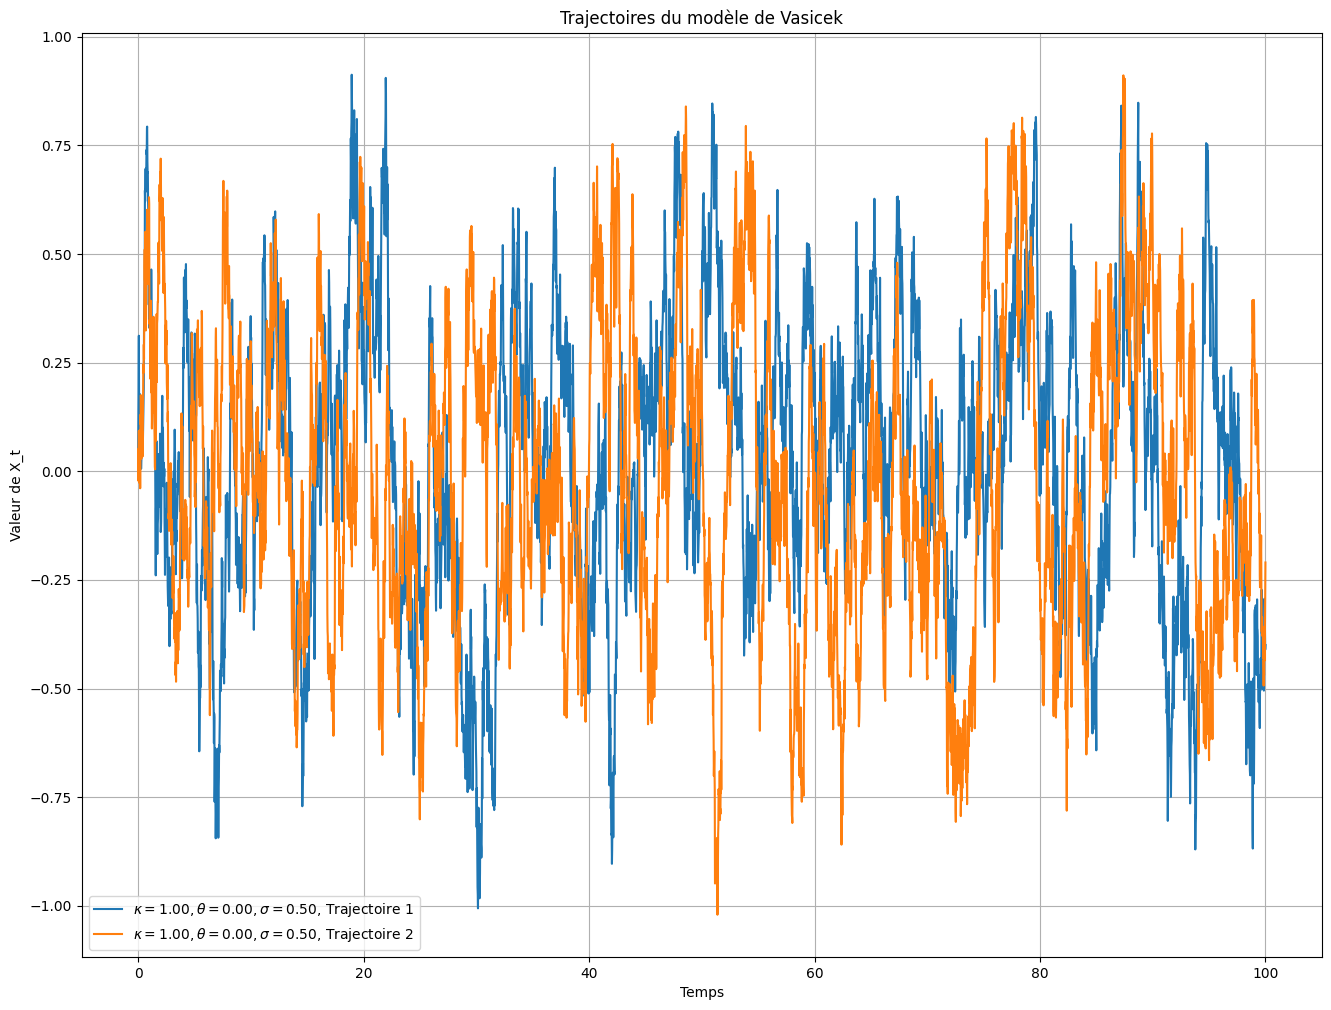

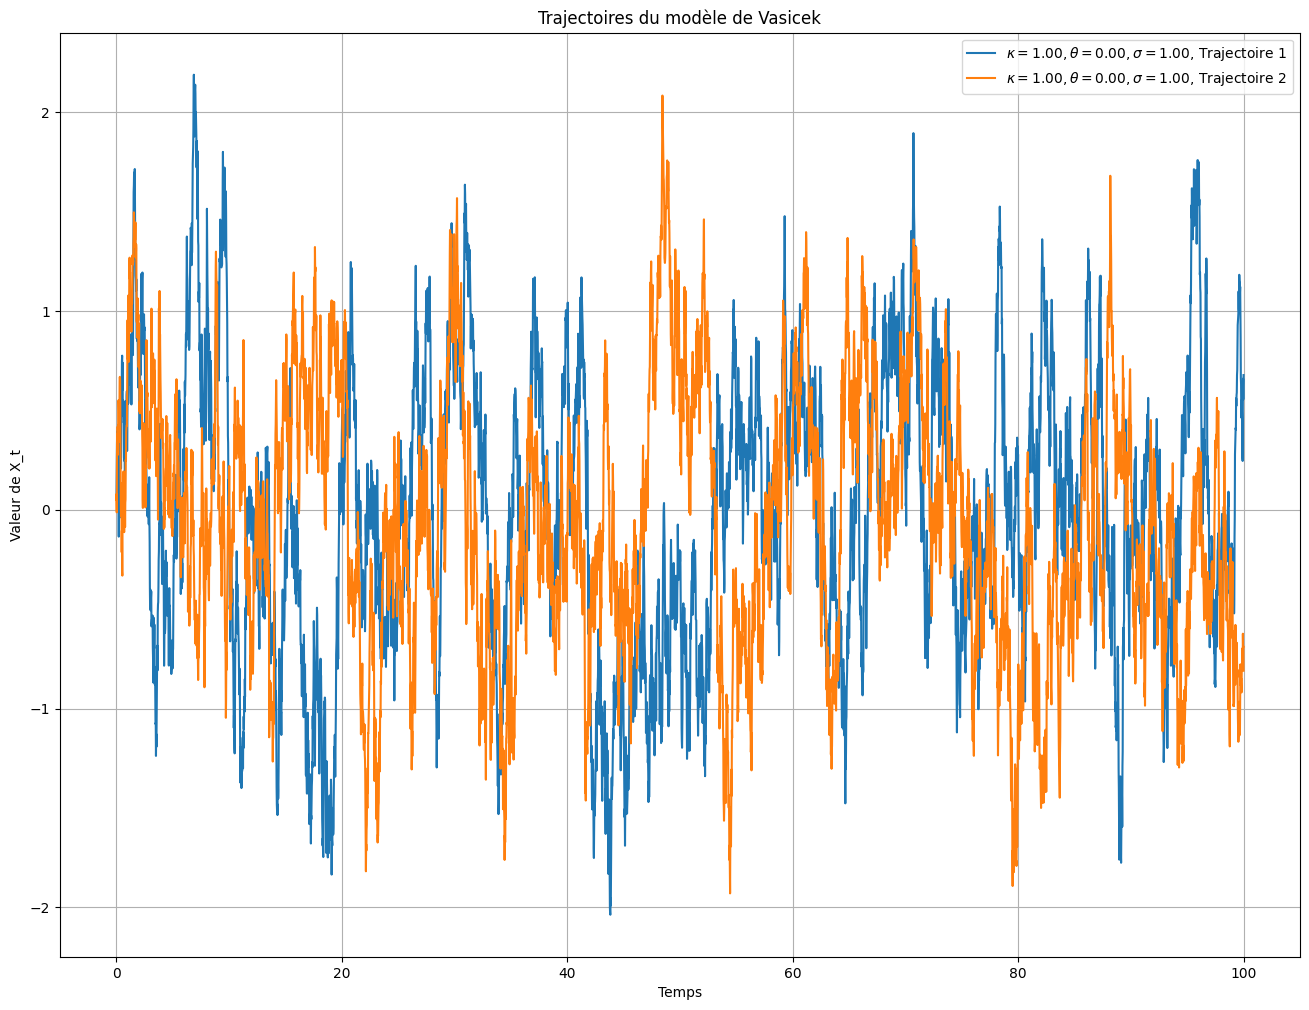

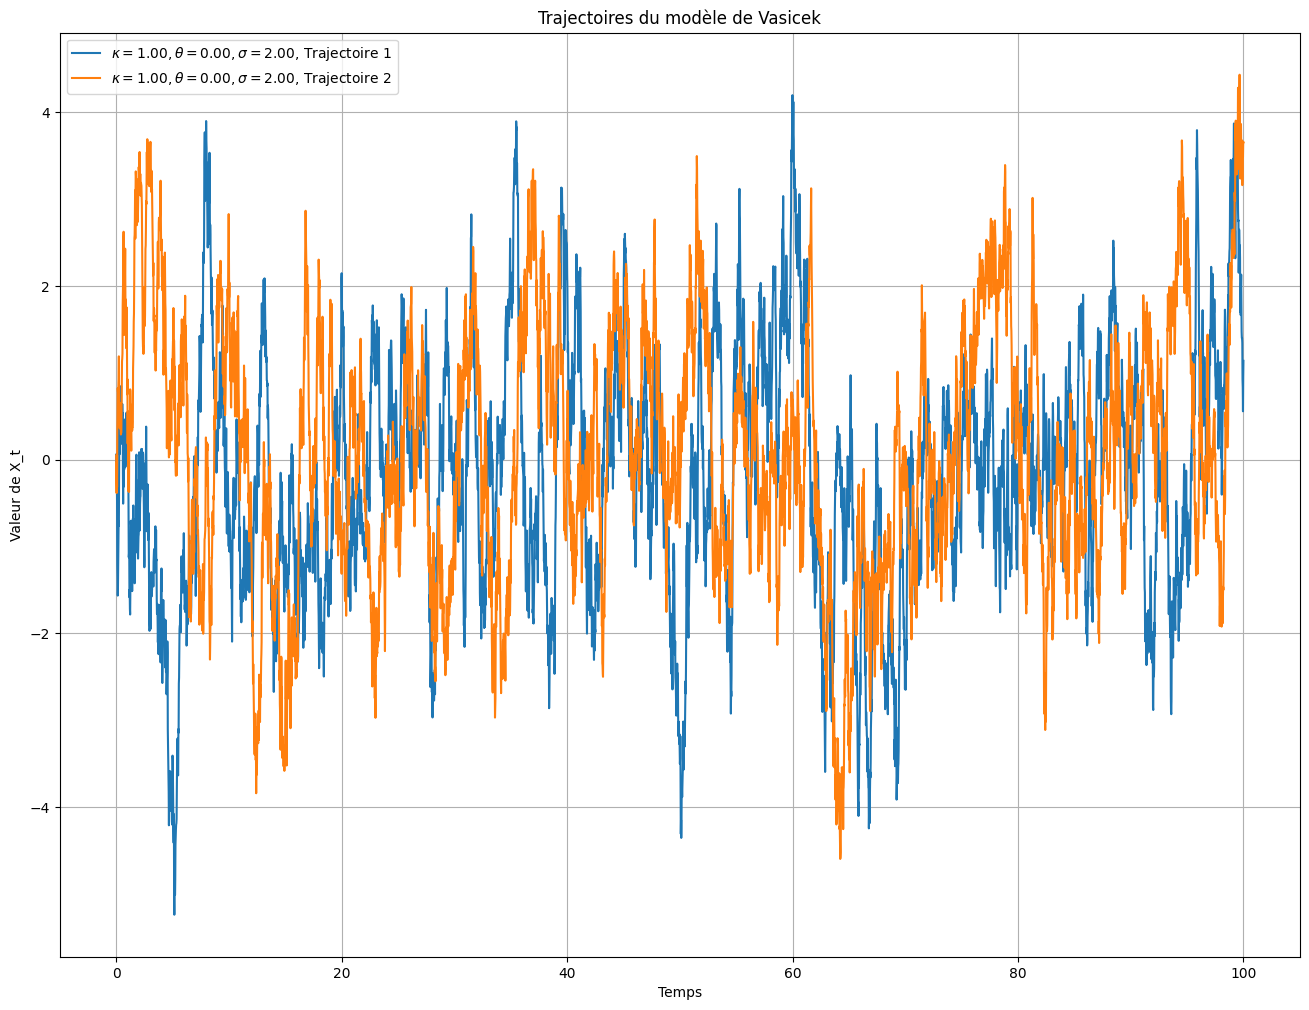

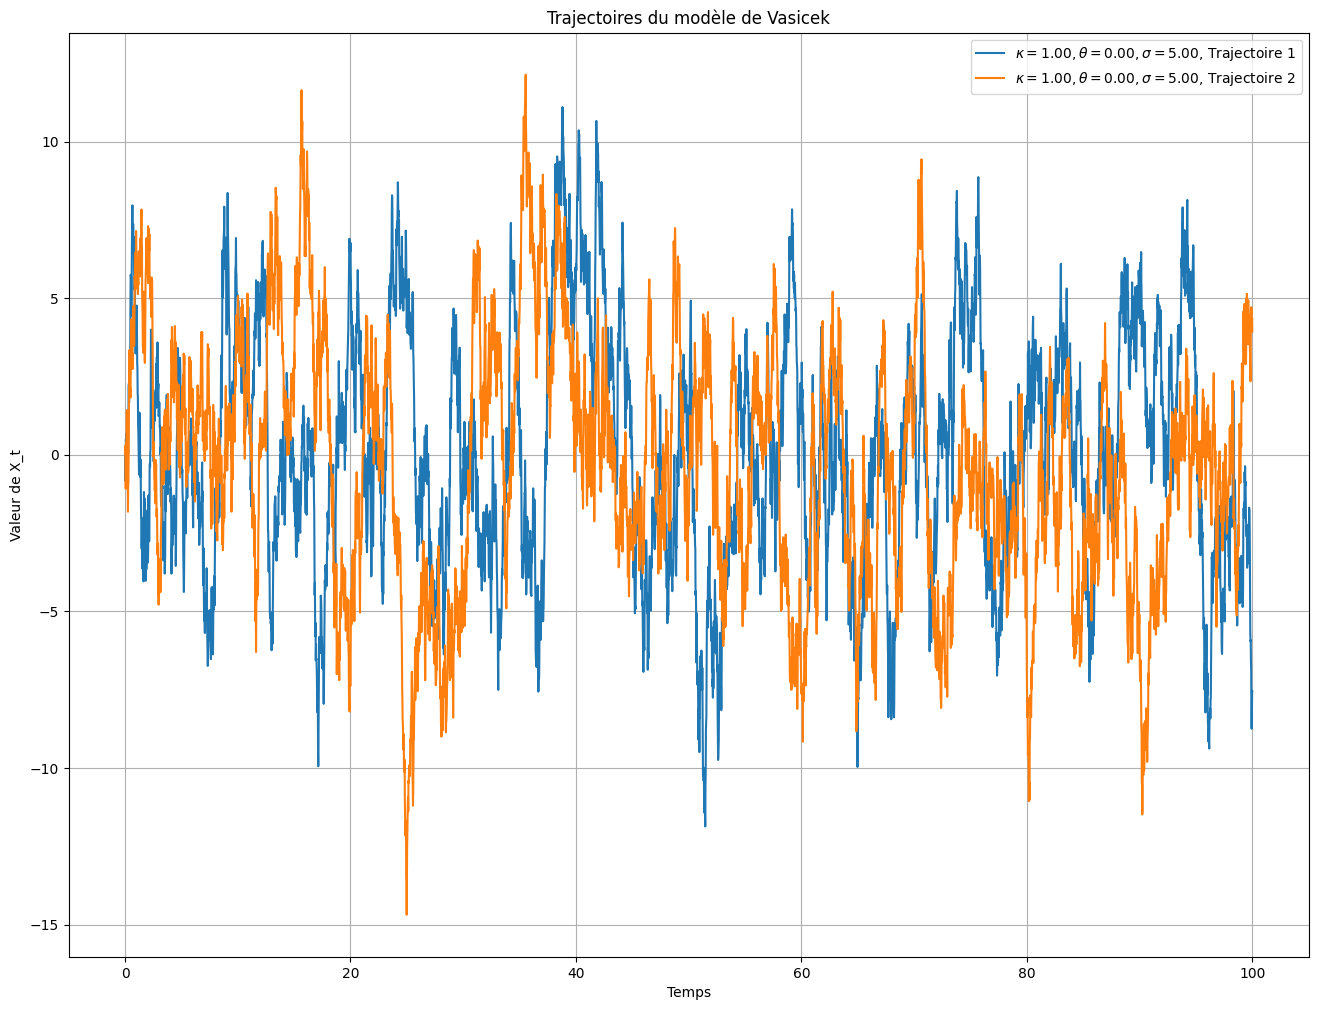

In [3]:
kappa = 1  
theta = 0  
X0 = 0.05  
N = 2  
n = 5000  
T = 100  

sigma_values = [0.5, 1, 2, 5]

for sigma in sigma_values:
    plt.figure(figsize=(16, 12))
    vasicek_process = Vasicek(kappa, theta, sigma)
    
    trajectories = vasicek_process.generate(X0, T, N, n)  
    
    time = np.linspace(0, T, n)
    for i in range(N):
        plt.plot(time, trajectories[i], label=f"$\\kappa = {kappa:.2f}, \\theta = {theta:.2f}, \\sigma = {sigma:.2f}$, Trajectoire {i+1}")
    plt.title("Trajectoires du modèle de Vasicek")
    plt.xlabel("Temps")
    plt.ylabel("Valeur de X_t")
    plt.legend()
    plt.grid(True)
    plt.show()


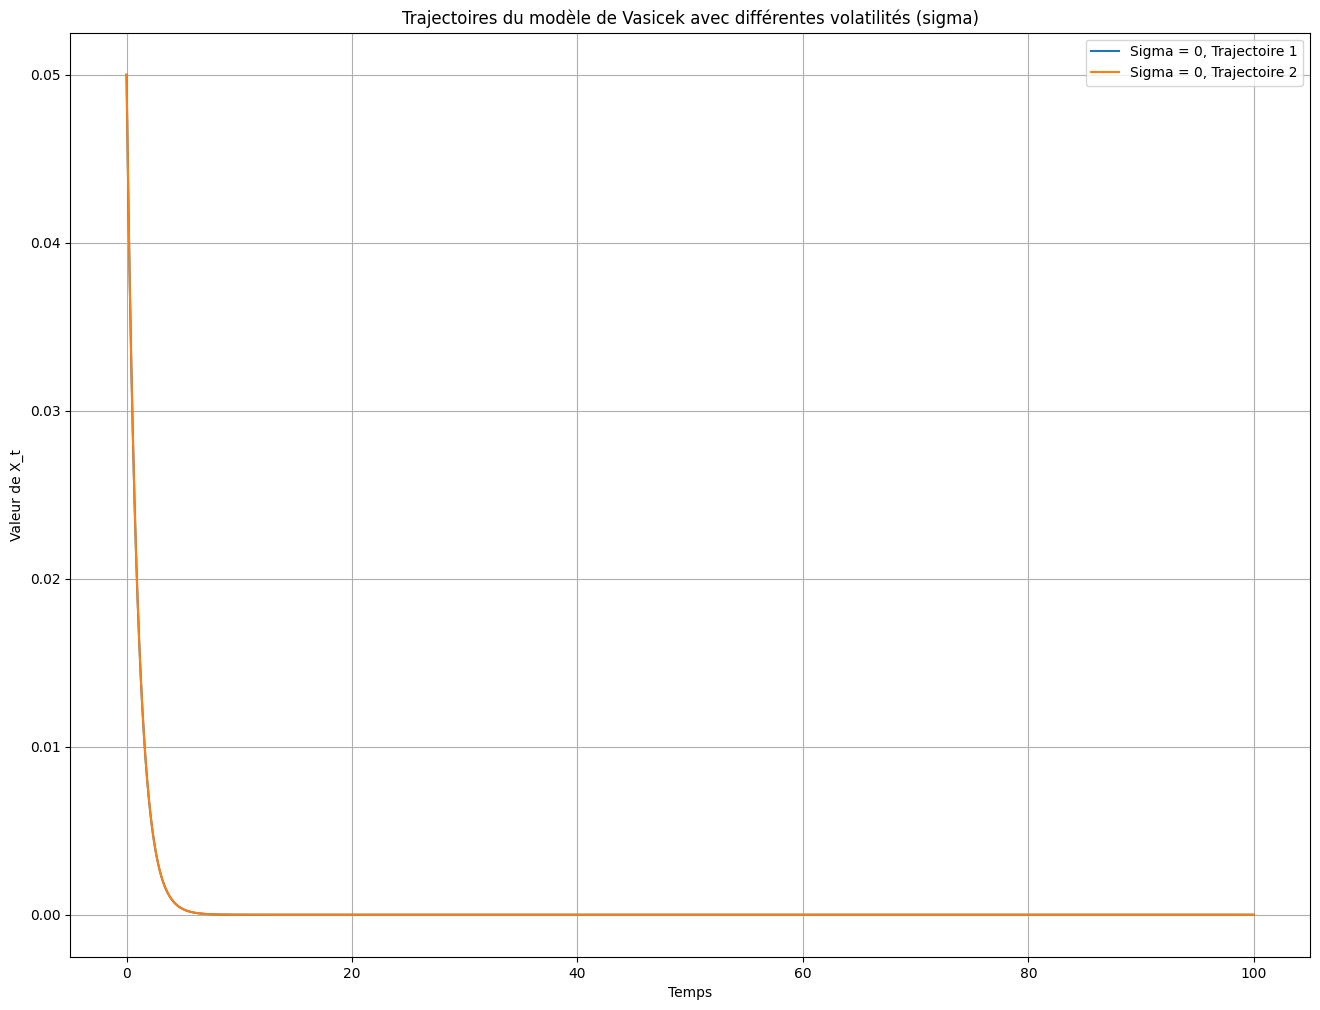

In [4]:
# Paramètres du modèle de Vasicek
kappa = 1  # vitesse de réversion vers la moyenne
theta = 0  # niveau de la moyenne à long terme
X0 = 0.05  # valeur initiale
N = 2  # nombre de trajectoires à générer
n = 5000  # nombre de pas de discrétisation    # Affichage des trajectoires générées pour chaque sigma

T = 100  # durée totale

# Liste des valeurs de sigma
sigma_values = [0]

# Créer un objet de la classe Vasicek et générer les trajectoires pour chaque valeur de sigma
for sigma in sigma_values:
    # Créer un objet avec la valeur de sigma courante
    plt.figure(figsize=(16, 12))
    vasicek_process = Vasicek(kappa, theta, sigma)
    
    # Générer les trajectoires
    trajectories = vasicek_process.generate(X0, T, N, n)  # Correction: Pass X0, T, N, n
    
    # Affichage des trajectoires générées pour chaque sigma
    time = np.linspace(0, T, n)
    for i in range(N):
        plt.plot(time, trajectories[i], label=f"Sigma = {sigma}, Trajectoire {i+1}")
    
    plt.title("Trajectoires du modèle de Vasicek avec différentes volatilités (sigma)")
    plt.xlabel("Temps")
    plt.ylabel("Valeur de X_t")
    plt.legend()
    plt.grid(True)
    plt.show()

La fonction suivante calcule la quantité :
$$\frac{1}{n} \sum_{k=0}^n f(X_{t_k})$$
Il s'agit de la moyenne temporelle du processus sur les $n$ instants.

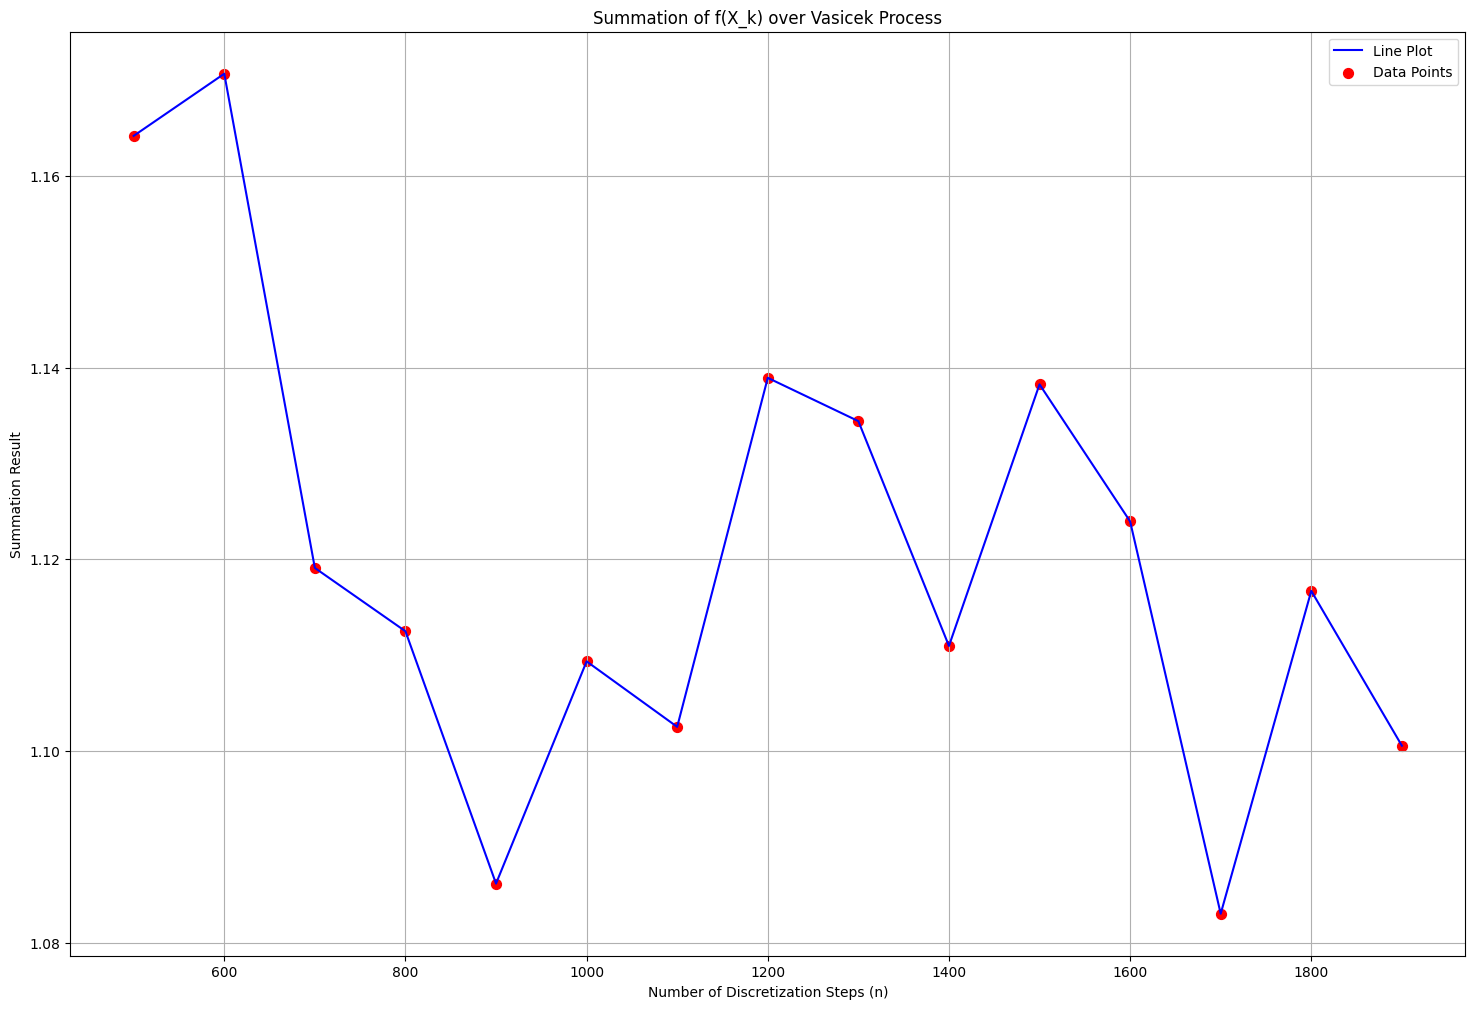

In [5]:
def calculate_sum(n, f, kappa=1, theta=1, sigma=0.5, X0=0.05,T=5000):
    """
    Calculate the summation: (1/n) * sum_{k=0}^n f(X_k), where X_k is generated by the Vasicek model.
    
    :param n: Number of steps in the discretization
    :param f: Function to apply to each X_k
    :param kappa: Speed of mean reversion
    :param theta: Long-term mean level
    :param sigma: Volatility
    :param X0: Initial value of the process
    :return: The computed summation
    """
    vasicek_process = Vasicek(kappa, theta, sigma)
      # Time horizon

    # Generate one trajectory
    trajectories = vasicek_process.generate(X0, T, 1, n)  # One trajectory, n steps
    res = 0
    trajectory = trajectories[0]  # Take the first trajectory
    res +=(1 / n) * sum(f(x) for x in trajectory)
    # Compute the summation
    return res

# Define the function to apply to each X_k
f = lambda x: x**2  # Example: Square of each value

n_values = range(500, 2000, 100)  # Range of n values for testing
Y = [calculate_sum(n, f) for n in n_values]  # Compute the result for each n
# Plot the results
plt.figure(figsize=(18, 12))
plt.plot(n_values, Y, label="Line Plot", color="blue")  # Line plot
plt.scatter(n_values, Y, label="Data Points", color="red", s=50)  # Scatter plot
plt.xlabel("Number of Discretization Steps (n)")
plt.ylabel("Summation Result")
plt.title("Summation of f(X_k) over Vasicek Process")
plt.grid(True)
plt.legend()  # Add a legend to differentiate the line and scatter plots
plt.show()

This function calculates this quantity :
$$\mathbb{E} (X_{\infty}^n)=\sum_{k=0}^n \binom{k}{n} \theta^{n-k} \frac{\sigma^k}{(2 \kappa)^{k/2}} \mathbb{E} (Z^k)$$
where $Z \sim \mathcal{N}(0,1)$

In [6]:
def expected_value_vasicek(power, theta, sigma, kappa):
    """
    Compute the expected value of the Vasicek process at X_n using the closed-form formula.
    
    :param n: Number of steps in the discretization
    :param theta: Long-term mean level
    :param sigma: Volatility
    :param kappa: Speed of mean reversion
    :return: The theoretical expected value
    """
    expected_sum = 0
    for k in range(power + 1):
        # Binomial coefficient
        binom_coeff = comb(power, k)
        
        # Factor for theta and sigma
        theta_factor = theta**(power - k)

        sigma_factor = sigma**k / (2 * kappa)**(k//2)
        
        # Expectation of Z^k
        if k % 2 == 0:  # Even powers of Z
            m = k // 2
            # For even k, the expectation of Z^{2m} is (2m-1)!! = (2m-1)*(2m-3)*...*1
            z_expectation = math.factorial(2 * m) // (2**m * math.factorial(m))  # Double factorial calculation
        else:  # Odd powers of Z
            z_expectation = 0
        
        # Add to the summation
        expected_sum += binom_coeff * theta_factor * sigma_factor * z_expectation
    
    return expected_sum


# Parameters for Vasicek
kappa_true = 1  # True speed of mean reversion
theta_true = 0.5  # True long-term mean
sigma_true = 0.2  # True volatility
n = 2

# Compute theoretical expectation
true_value = expected_value_vasicek(n, theta, sigma, kappa)
print("Theoretical Expected Value:", true_value)


Theoretical Expected Value: 0.0


Theoretical Expected Value: 0.27
Average of computed Summation: 0.2712595206536122


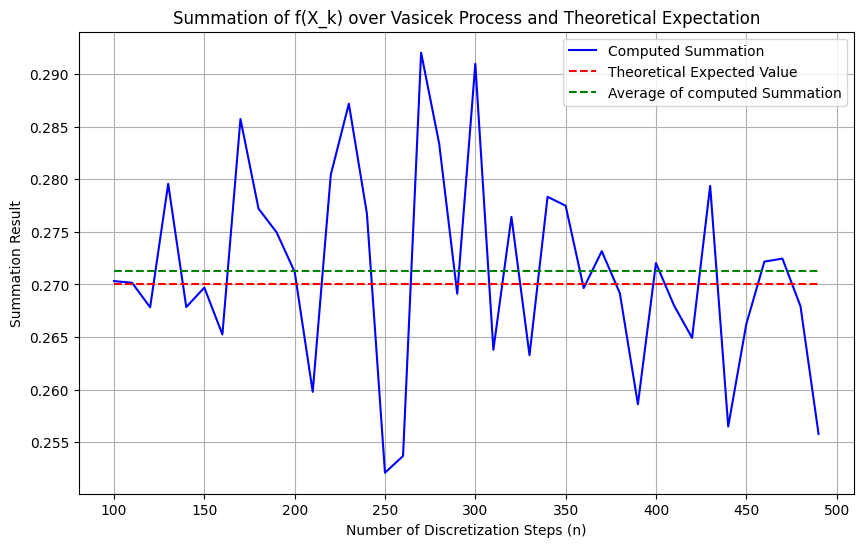

In [7]:
# Example parameters
kappa = 1  # Speed of mean reversion
theta = 1  # Long-term mean level
sigma = 0  # Volatility
X0 = 0.05  # Initial value
N = 1  # Only 1 trajectory for the summation computation
n_values = range(100, 500, 10)  # Range of n values for testing
n = 2 # Choose a large n for comparison

# Define the function to apply to each X_k
f = lambda x: x**n# Example: x^3

# Compute the summation for each value of n
Y = [calculate_sum(n, f, kappa=kappa_true, theta=theta_true, sigma=sigma_true, X0=X0) for n in n_values]
y0 = sum(Y)/len(Y)
# Compute the true value of the expectation
true_value = expected_value_vasicek(n, theta_true, sigma_true, kappa_true)
Y0 = [true_value for _ in n_values]  # Create a constant list for the theoretical expected value
Y1 = [y0 for _ in n_values]
# Print the theoretical expected value
print("Theoretical Expected Value:", true_value)
print("Average of computed Summation:", y0)
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_values, Y, label="Computed Summation", color="blue")
plt.plot(n_values, Y0, label="Theoretical Expected Value", color="red", linestyle="--")
plt.plot(n_values, Y1, label="Average of computed Summation", color="green", linestyle="--")
plt.xlabel("Number of Discretization Steps (n)")
plt.ylabel("Summation Result")
plt.title("Summation of f(X_k) over Vasicek Process and Theoretical Expectation")
plt.legend()
plt.grid(True)
plt.show()


# Estimation by "pure" moments

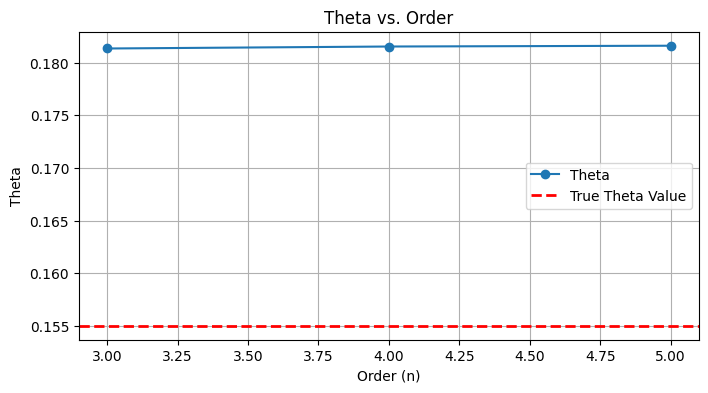

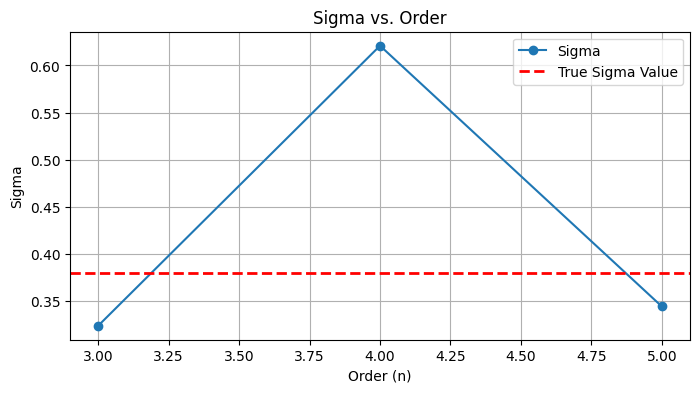

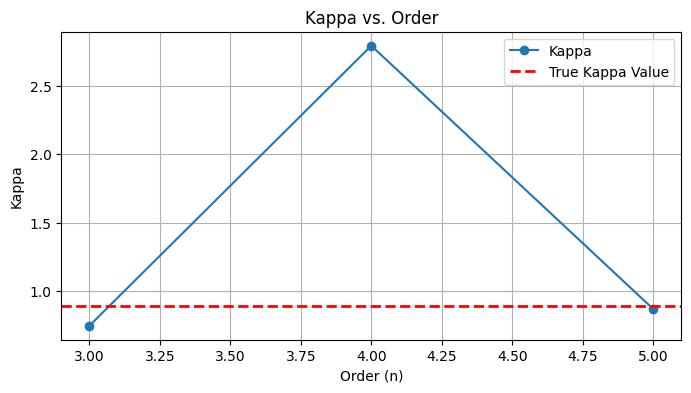

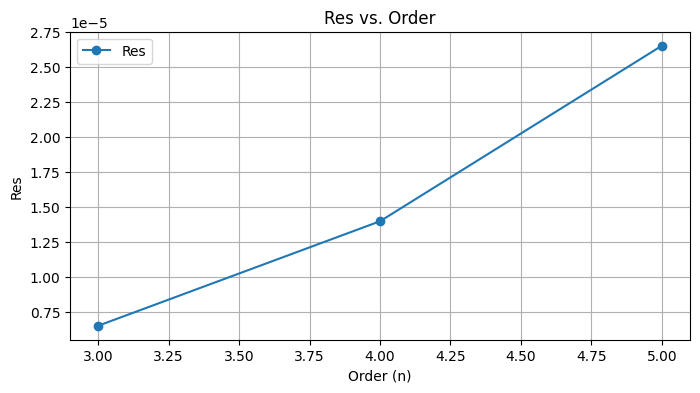

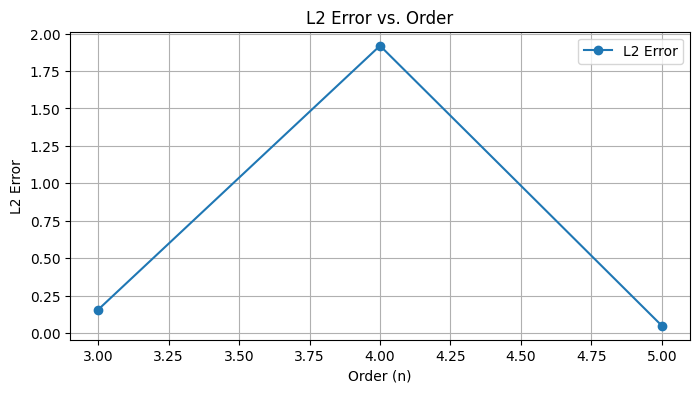

In [8]:


true_theta = 0.155
true_sigma = 0.38
true_kappa = 0.89

def empirical_value_vasicek(X, order):
    """Calcule la valeur empirique du moment d'ordre donné."""
    return np.mean(X**order)

def pure_moments_calibration(X, max_order):
    """Calibre les paramètres du modèle de Vasicek en minimisant l'erreur des moments purs."""
    orders = np.arange(1, max_order + 1)
    y_obs = np.array([empirical_value_vasicek(X, i) for i in orders])

    def cost(params):
        theta, sigma, kappa = params
        errors = [
            expected_value_vasicek(i, theta, sigma, kappa) - y_obs[i-1]
            for i in range(1, max_order + 1)
        ]
        return np.sum(np.square(errors))

    result = float('inf')
    best_params = None
    max_iterations = 10
    epsilon = 1e-7
    for i in range(1, max_iterations+1):
        for j in range(1, max_iterations+1):
            for k in range(1, max_iterations+1):
                initial_guess = [i / max_iterations, j / max_iterations, k / max_iterations]
                res = minimize(cost, initial_guess, method='Nelder-Mead', bounds=[(epsilon, None), (epsilon, None), (epsilon, None)])
                
                if res.fun < result:
                    result = res.fun
                    best_params = res.x

    return *best_params, result

# Paramètres
n = 1000
T = 100
X0 = 0.1

# Générer les données
vasicek_process = Vasicek(true_kappa, true_theta, true_sigma)
X = vasicek_process.generate(X0, T, 1, n)

# Calibrer pour chaque ordre
max_order = 5
n_values = range(3, max_order + 1)
calibration_values = [pure_moments_calibration(X, n) for n in n_values]

# Extraction des paramètres calibrés
theta_values = [params[0] for params in calibration_values]
sigma_values = [params[1] for params in calibration_values]
kappa_values = [params[2] for params in calibration_values]
res_values = [params[3] for params in calibration_values]

# Calcul du L2 error
l2_errors = [
    np.sqrt((theta - true_theta) ** 2 + (sigma - true_sigma) ** 2 + (kappa - true_kappa) ** 2)
    for theta, sigma, kappa in zip(theta_values, sigma_values, kappa_values)
]

# Création d'un dictionnaire pour les paramètres
parameters = {
    'Theta': theta_values,
    'Sigma': sigma_values,
    'Kappa': kappa_values,
    'Res': res_values,
    'L2 Error': l2_errors
}

# Tracé des graphes
for param_name, param_values in parameters.items():
    plt.figure(figsize=(8, 4))
    plt.plot(n_values, param_values, marker='o', linestyle='-', label=param_name)
    
    # Ligne horizontale de la vraie valeur sauf pour 'Res' et 'L2 Error'
    if param_name in ['Theta', 'Sigma', 'Kappa']:
        plt.axhline(y={'Theta': true_theta, 'Sigma': true_sigma, 'Kappa': true_kappa}[param_name], 
                    color='red', linestyle='--', linewidth=2, label=f'True {param_name} Value')

    # Ajout des labels et du titre
    plt.xlabel('Order (n)')
    plt.ylabel(param_name)
    plt.title(f'{param_name} vs. Order')
    plt.legend()
    plt.grid(True)
    plt.show()


## Estimation by First and Second-Order Moments

Here, I will present my theoretical results used for estimation in the Vasicek model.  
I used only the first two moments to estimate both $\sigma$ and $\kappa $. We will later see if we can improve this method.

$$
\bar{\theta} = \frac{1}{n} \sum_{i=1}^{n} X_i
$$

Let us define:

$$
X_0 = \bar{\theta}^2 - \frac{1}{n} \sum_{i=1}^{n} X_i X_{i+1}
$$

$$
X_1 = \bar{\theta}^2 - \frac{1}{n} \sum_{i=1}^{n} X_i X_{i+2}
$$

$$
h = \frac{T}{n}
$$
# Objective Function Minimization
The objective function is:
$$
L(\kappa, \sigma^2) = \left( \frac{\sigma^2}{2\kappa} e^{-\kappa h} - X_0 \right)^2 + \left( \frac{\sigma^2}{2\kappa} e^{-2\kappa h} - X_1 \right)^2 
$$



This is clearly achieved when :
$$\frac{\sigma^2}{2\kappa} e^{-\kappa h} - X_0  = 0 $$
and 
$$ \frac{\sigma^2}{2\kappa} e^{-2\kappa h} - X_1 =  0 $$

$$ e^{-\kappa h} = \frac{X_1}{X_0} $$
$$ \sigma ^2  = 2 \kappa  X_0 e^{\kappa h} = \frac{2 \kappa X_0^2}{X_1} $$


Finally, we have these results : 
$$\bar{\kappa} = \frac{1}{h} \ln( {\frac{(\frac{1}{n} \sum_{i=1}^{n} X_i)^2 - \frac{1}{n} \sum_{i=1}^{n} X_i X_{i+1}}{(\frac{1}{n} \sum_{i=1}^{n} X_i)^2 - \frac{1}{n} \sum_{i=1}^{n} X_i X_{i+2}}})$$
$\newline$

$$\bar {\sigma^2} = 2 \bar {\kappa} \frac{((\frac{1}{n} \sum_{i=1}^{n} X_i)^2 - \frac{1}{n} \sum_{i=1}^{n} X_i X_{i+1})^2}{(\frac{1}{n} \sum_{i=1}^{n} X_i)^2 - \frac{1}{n} \sum_{i=1}^{n} X_i X_{i+2}}$$
$$\bar{\theta} = \frac{1}{n} \sum_{i=1}^{n} X_i$$

This is done with the normal moments method. We should of course extend this to the generalized method of moments and with lag terms.
An intersting property we have here is, 
$$
\left(\sigma e^{-\kappa(t_{k+1}-t_k)} \int_{t_k}^{t_{k+1}} e^{-\kappa(t-s)} \, dW_s\right)_k
$$
are i.i.d. with law :
$$
\mathcal{N}\!\left(0, \frac{\sigma^2}{2\kappa}\Bigl(1 - e^{-2\kappa h}\Bigr)\right),
$$
where $(h = t_{k+1} - t_k).$

$$
X_{t_j} \mid X_{t_i} \sim \mathcal{N}\!\left( e^{-\kappa (t_j-t_i)} X_{t_i} + \theta\Bigl(1 - e^{-\kappa (t_j-t_i)}\Bigr), \; \frac{\sigma^2}{2\kappa}\Bigl(1 - e^{-2\kappa (t_j-t_i)}\Bigr) \right).
$$

Here we do the implementation of the estimator of the vasicek model by using the forumlas found below for $\kappa,\sigma,\theta.$
$\newline$
These formulas were proved using the first and second lagging terms and the mean to estimate $\theta$.

I will add to that the estiamation using the first 3 pure moments after and inversing the functions.

I wil try after that to add a weight Matrix $W$ that will make the estimation way better.

According to the paper we have on GMM, we have this result we could apply into our model : 
Under some conditions we have : 
$$
\hat{\theta}_T \xrightarrow{p} \theta_0;

\newline

T^{1/2}(\hat{\theta}_T - \theta_0) \xrightarrow{d} N(0, V)
$$
where
$$

V = \left[ G(\theta_0)^T W G(\theta_0) \right]^{-1} G(\theta_0)^T W S(\theta_0) W G(\theta_0) \left[ G(\theta_0)^T W G(\theta_0) \right]^{-1}
\newline
$$

$$
\newline
S(\theta) = \lim_{T \to \infty} \operatorname{Var} \left[ T^{1/2} g_T (\theta) \right].
\newline
\hat {\theta}_T = (\hat{\kappa},\hat{\theta},\hat{\sigma ^2})
$$
$$ f(v_T,\theta) $$
is a q vector function where
 $$ \mathbb{E}(f(v_T,\theta))=0 $$


In [9]:

# True Vasicek parameters
true_theta = 0.155
true_sigma = 0.38
true_kappa = 0.89
T = 100         # Total time period
n_simulations = 100  # Number of simulations
n_points = 5000       # Number of discretization steps per trajectory



def moment_estimators(X, T):
    h = T / len(X)
    n = len(X) - 2  
    mean_X = np.mean(X)
    sum_X = np.sum(X[:-1]) / n
    sum_X2 = np.sum(X[:-2]) / n
    sum_X_X1 = np.sum(X[:-1] * X[1:]) / n
    sum_X_X2 = np.sum(X[:-2] * X[2:]) / n
    
    numerator = (sum_X ** 2 - sum_X_X1)
    denominator = (sum_X ** 2 - sum_X_X2)
    
    kappa_hat = (1 / h) * np.log(numerator / denominator)
    sigma2_hat = -2 * kappa_hat * (numerator ** 2) / denominator  
    theta_hat = mean_X
    
    return theta_hat, sigma2_hat, kappa_hat

# Run simulations
theta_estimates, sigma_estimates, kappa_estimates = [], [], []

for _ in range(n_simulations):
    vasicek_process = Vasicek(true_kappa, true_theta, true_sigma)
    X = vasicek_process.generate(X0=0.1, T=T, N=1, n=n_points)[0]
    theta_hat, sigma2_hat, kappa_hat = moment_estimators(X, T)
    theta_estimates.append(theta_hat)
    sigma_estimates.append(np.sqrt(sigma2_hat))  # Convert variance to standard deviation
    kappa_estimates.append(kappa_hat)

# Compute empirical mean and variance
theta_mean, theta_var = np.mean(theta_estimates), np.var(theta_estimates, ddof=1)
sigma_mean, sigma_var = np.mean(sigma_estimates), np.var(sigma_estimates, ddof=1)
kappa_mean, kappa_var = np.mean(kappa_estimates), np.var(kappa_estimates, ddof=1)

print(f"θ Estimate: Mean = {theta_mean:.5f}, Variance = {theta_var:.5f}, True theta = {true_theta:.5f}")
print(f"σ Estimate: Mean = {sigma_mean:.5f}, Variance = {sigma_var:.5f}, True sigma = {true_sigma:.5f}")
print(f"κ Estimate: Mean = {kappa_mean:.5f}, Variance = {kappa_var:.5f}, True kappa = {true_kappa:.5f}")  

θ Estimate: Mean = 0.15652, Variance = 0.00167, True theta = 0.15500
σ Estimate: Mean = 0.38157, Variance = 0.00004, True sigma = 0.38000
κ Estimate: Mean = 0.95688, Variance = 0.02153, True kappa = 0.89000


In [10]:
# Generate Vasicek process trajectories 
# True parameters
kappa_true = 0.892  # Vitesse de retour à la moyenne
theta_true = 0.09  # Moyenne long-terme
sigma_true = 0.033  # Volatilité
vasicek_process = Vasicek(kappa_true, theta_true, sigma_true)
X0 = 0.1  # Initial value
N = 1  # Number of trajectories
n = 1000  # Number of time steps
T =  1000   # Time horizon
trajectories = vasicek_process.generate(X0, T, N, n)
trajectory = trajectories[0]
s = 0
for i in range(len(trajectory)) :
    trajectory[i] =trajectory[i] 


In [11]:


# Theoretical covariance function
def theoretical_covariance(h, kappa, sigma):
    return (sigma**2 / (2 * kappa)) * np.exp(-kappa * h)

# Empirical covariance function
def empirical_covariance(X, n, T, theta_emp, h):
    k0 = int(n * h / T)  # Convert lag h to index
    cov = 0
    for k in range(n - k0):
        cov += (X[k] * X[k + k0]) / (n - k0)
    return cov - theta_emp**2

# Function to estimate kappa and sigma using minimization
def estimate_kappa_sigma(X, n, T, theta_emp, lags):
    # Compute empirical covariance for the given lags
    covariances = np.array([empirical_covariance(X, n, T, theta_emp, h) for h in lags])

    # Loss function to minimize
    def loss(params):
        kappa, sigma = params
        return np.sum((covariances - theoretical_covariance(lags, kappa, sigma)) ** 2)

    # Initial guesses and bounds
    bounds = [(1e-6, None), (1e-6, None)]  # Ensure positive kappa and sigma

    # Use multiple random initializations
    best_params = None
    best_loss = float('inf')
    for _ in range(10):
        initial_guess = np.random.uniform(0.1, 1, size=2)  # Randomized start points
        res = minimize(loss, initial_guess, method='L-BFGS-B', bounds=bounds)
        if res.fun < best_loss:
            best_loss = res.fun
            best_params = res.x

    return best_params[0], best_params[1]


Empirical theta is: 0.09019892891345457
True theta is: 0.09
Number of Lags:  2


Number of Lags:  5
Number of Lags:  8
Number of Lags:  11
Number of Lags:  14
Number of Lags:  17
Number of Lags:  20
Number of Lags:  23
Number of Lags:  26
Number of Lags:  29
Number of Lags:  32
Number of Lags:  35
Number of Lags:  38
Number of Lags:  41
Number of Lags:  44
Number of Lags:  47


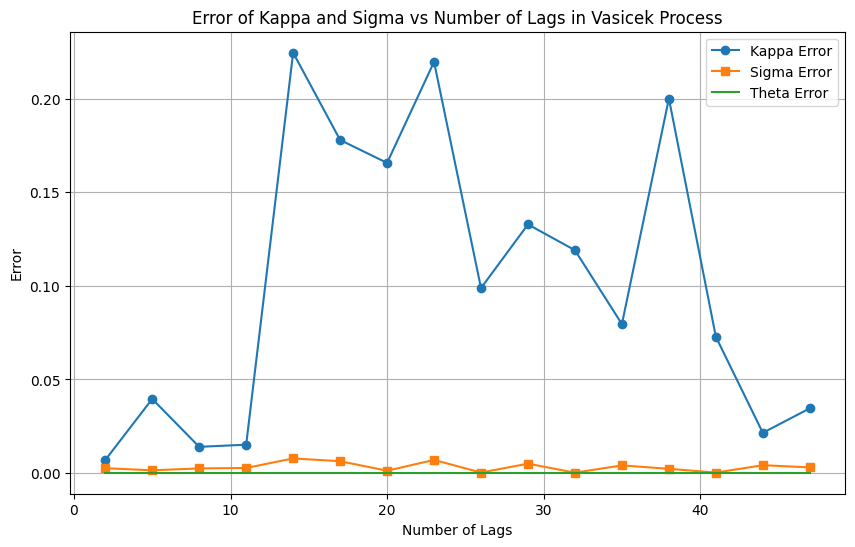

True kappa is: 0.892
True sigma is: 0.033
Estimated kappa is: 0.9265835384126261
Estimated sigma is: 0.0360457413931289


In [12]:

# Compute empirical mean
theta_emp = np.mean(trajectory)
print("Empirical theta is:", theta_emp)
print("True theta is:", theta_true)

# Define the range of lags
num_lags_list = np.arange(2, 50,3)  # Start with 20, increase by 20, up to 200
kappa_errors = []
sigma_errors = []
theta_errors = []
kappa_est = -1 
sigma_est = -1
# Loop over the number of lags to calculate errors
for num_lags in num_lags_list:
    print("Number of Lags: ", num_lags)
    lags = np.array([i * T / n for i in range(num_lags)])  # Define lags
    kappa_est, sigma_est = estimate_kappa_sigma(trajectory, n, T, theta_emp, lags)
    kappa_errors.append(np.abs(kappa_est - kappa_true))  # Absolute error for kappa
    sigma_errors.append(np.abs(sigma_est - sigma_true))  # Absolute error for sigma
    theta_errors.append(np.abs(theta_emp-theta_true))

# Plot the errors
plt.figure(figsize=(10, 6))
plt.plot(num_lags_list, kappa_errors, label='Kappa Error', marker='o')
plt.plot(num_lags_list, sigma_errors, label='Sigma Error', marker='s')
plt.plot(num_lags_list,theta_errors,label ="Theta Error")
plt.xlabel('Number of Lags')
plt.ylabel('Error')
plt.title('Error of Kappa and Sigma vs Number of Lags in Vasicek Process')
plt.legend()
plt.grid(True)
plt.show()
print("True kappa is:", kappa_true)
print("True sigma is:", sigma_true)
print("Estimated kappa is:", kappa_est)
print("Estimated sigma is:", sigma_est)

In [13]:
# Number of simulations
num_simulations = 10

# Lists to store estimated values
kappa_estimates = []
sigma_estimates = []
kappa_true = 0.892  # Vitesse de retour à la moyenne
theta_true = 0.09  # Moyenne long-terme
sigma_true = 0.033  # Volatilité
# Run simulations
for _ in range(num_simulations):
    # Generate Vasicek process trajectories 
    # True parameters

    vasicek_process = Vasicek(kappa_true, theta_true, sigma_true)
    X0 = 0.1  # Initial value
    N = 1  # Number of trajectories
    n = 1000  # Number of time steps
    T =  100  # Time horizon
    trajectories = vasicek_process.generate(X0, T, N, n)
    trajectory = trajectories[0]

    # Compute empirical mean
    theta_emp = np.mean(trajectory)

    # Define the range of lags
    num_lags_list = np.arange(2, 50, 3)  
    kappa_errors = []
    sigma_errors = []

    # Loop over the number of lags
    for num_lags in num_lags_list:
        lags = np.array([i * T / n for i in range(num_lags)])  
        kappa_est, sigma_est = estimate_kappa_sigma(trajectory, n, T, theta_emp, lags)
        kappa_errors.append(np.abs(kappa_est - kappa_true))
        sigma_errors.append(np.abs(sigma_est - sigma_true))

    # Store last estimates (or take an average over all if you prefer)
    kappa_estimates.append(kappa_est)
    sigma_estimates.append(sigma_est)

# Compute empirical mean and variance of the estimates
kappa_mean = np.mean(kappa_estimates)
kappa_variance = np.var(kappa_estimates)
sigma_mean = np.mean(sigma_estimates)
sigma_variance = np.var(sigma_estimates)

# Print results
print("Empirical Mean of Estimated Kappa:", kappa_mean)
print("Empirical Variance of Estimated Kappa:", kappa_variance)
print("Empirical Mean of Estimated Sigma:", sigma_mean)
print("Empirical Variance of Estimated Sigma:", sigma_variance)


Empirical Mean of Estimated Kappa: 1.2913674269925022
Empirical Variance of Estimated Kappa: 0.09666833769414959
Empirical Mean of Estimated Sigma: 0.03998874694351941
Empirical Variance of Estimated Sigma: 1.76584364596312e-05


<h1>Maximum Likelihood Estimator (MLE)</h1>


The fixed $\delta$ results for the maximum likelihood estimators of the Vasicek process are given in the following theorems.


## Parameter Estimation in the Vasicek Model

We estimate the parameters $\kappa$, $\alpha$, and $\sigma^2$ using the following equations from C.Y. Tang and S.X. Chen (2009):

\begin{align*}
    \hat{\kappa} = -\frac{1}{\delta} \log(\hat{\beta}_1), \quad 
    \hat{\alpha} = \hat{\beta}_2, \quad 
    \hat{\sigma}^2 = \frac{2\hat{\kappa} \hat{\beta}_3}{1 - \hat{\beta}_1^2}
\end{align*}

where

\begin{align*}
    \hat{\beta}_1 = \frac{\frac{1}{n} \sum\limits_{i=1}^{n} X_i X_{i-1} - 
    \left( \frac{1}{n} \sum\limits_{i=1}^{n} X_i \right) 
    \left( \frac{1}{n} \sum\limits_{i=1}^{n} X_{i-1} \right)}
    {\frac{1}{n} \sum\limits_{i=1}^{n} X_{i-1}^2 - 
    \left( \frac{1}{n} \sum\limits_{i=1}^{n} X_{i-1} \right)^2}
\end{align*}

\begin{align*}
    \hat{\beta}_2 = \frac{\frac{1}{n} \sum\limits_{i=1}^{n} (X_i - \hat{\beta}_1 X_{i-1})}{1 - \hat{\beta}_1}
\end{align*}

\begin{align*}
    \hat{\beta}_3 = \frac{1}{n} \sum\limits_{i=1}^{n} 
    \left( X_i - \hat{\beta}_1 X_{i-1} - \hat{\beta}_2 (1 - \hat{\beta}_1) \right)^2
\end{align*}




\begin{align*}
    B_1(\theta, \delta) &= \frac{5}{2} + e^{\kappa \delta} + e^{2\kappa \delta / 2}, \\
    B_2(\theta, \delta) &= -\sigma^2 \delta^{-1} 
    \left[ \kappa^{-1} 
    \left( 2 - \kappa \delta - \frac{1}{2} e^{2\kappa \delta} (1 - e^{-\kappa \delta}) \right) 
    - 4\delta(1 - e^{-2\kappa \delta})^{-1} e^{-2\kappa \delta} 
    \right], \\
    V_1(\theta, \delta) &= \delta^{-1} (e^{2\kappa \delta} - 1), \\
    V_2(\theta, \delta) &= \sigma^2 (2\kappa)^{-1} \delta (e^{\kappa \delta} - 1)^{-1} (e^{\kappa \delta} + 1), \\
    V_3(\theta, \delta) &= \sigma^4 (\kappa \delta)^{-2} 
    \left[ 2(\kappa \delta)^2 + (e^{\kappa \delta} - e^{-\kappa \delta}) 
    \left( 1 - \frac{2\kappa \delta e^{-2\kappa \delta}}{1 - e^{-2\kappa \delta}} \right) 
    \right].
\end{align*}

Theorem  : For a stationary Vasicek process, as $n \to \infty$ while $\delta$ is fixed,

\begin{align*}
    \mathbb{E}(\hat{\kappa}) &= \kappa + (n\delta)^{-1} B_1(\theta, \delta) + O(n^{-2}), \\
    \text{Var}(\hat{\kappa}) &= (n\delta)^{-1} V_1(\theta, \delta) + O(n^{-2}), \\
    \mathbb{E}(\hat{\alpha}) &= \alpha + O(n^{-2}), \\
    \text{Var}(\hat{\alpha}) &= (n\delta)^{-1} V_2(\theta, \delta) + O(n^{-2}), \\
    \mathbb{E}(\hat{\sigma}^2) &= \sigma^2 + n^{-1} B_2(\theta, \delta) + O(n^{-2}), \\
    \text{Var}(\hat{\sigma}^2) &= n^{-1} V_3(\theta, \delta) + O(n^{-2}).
\end{align*}

For a stationary Vasicek process, let 
$$
\hat{\theta} = (\hat{\kappa}, \hat{\alpha}, \hat{\sigma}^2)^T
$$
and 
$$
\theta = (\kappa, \alpha, \sigma^2)^T.
$$
Then, as \( n \to \infty \),
$$
\sqrt{n} (\hat{\theta} - \theta) \xrightarrow{d} \mathcal{N}(0, \Omega_1),
$$
where 
$$
\Omega_1 = \operatorname{diag} \left( \delta^{-1} V_1(\theta, \delta), \delta^{-1} V_2(\theta, \delta), V_3(\theta, \delta) \right).
$$


In [14]:
def negative_log_likelihood(params):
    """
    Compute the log-likelihood for the Vasicek process given parameters.
    
    :param sigma: Volatility parameter (standard deviation)
    :param theta: Long-term mean level
    :param kappa: Speed of mean reversion
    :param n: Number of discretization steps
    :param T: Total time period (default is 1)
    
    :return: Log-likelihood value
    """
    # Create the Vasicek process model with given parameters
 # Take the first trajectory as the observed data
    sigma, theta, kappa = params

    dt = T / n  # Time step size

    # Initialize log-likelihood value
    log_likelihood_value = 0

    # First part of the log-likelihood
    term1 = -n / 2 * np.log(sigma**2 / (2 * kappa * (1 - np.exp(-2 * kappa * dt))))
    log_likelihood_value += term1
    # Third part: Sum of squared residuals
    residual_sum = 0
    for i in range(1, n):
        expected_value = trajectory[i - 1] * np.exp(-kappa * dt) + theta * (1 - np.exp(-kappa * dt))
        residual = trajectory[i] - expected_value
        residual_sum += residual**2
    
    # Fourth part: the sum over residuals
    term3 = -(kappa / (sigma**2 * (1 - np.exp(-2 * kappa * dt)))) * residual_sum
    log_likelihood_value += term3

    return -log_likelihood_value


In [15]:
def estimate_parameters(trajectory = trajectory, T = T):
    n = len(trajectory)
    delta_t = T / n
    Rt = np.array(trajectory)
    
    # Calculate terms
    Rt_shifted = Rt[:-1]  # R_{t_{i-1}}
    Rt_current = Rt[1:]  # R_{t_i}
    
    #  (kappa)
    mean_RtRt_shifted = np.mean(Rt_current * Rt_shifted)
    mean_Rt = np.mean(Rt_current)
    mean_Rt_shifted = np.mean(Rt_shifted)
    mean_Rt_shifted_squared = np.mean(Rt_shifted ** 2)
    
    numerator_alpha = mean_RtRt_shifted - mean_Rt * mean_Rt_shifted
    denominator_alpha = mean_Rt_shifted_squared - mean_Rt_shifted ** 2
    kappa = -1 / delta_t * np.log(numerator_alpha / denominator_alpha)
    
    #  (theta)
    numerator_theta = np.sum(Rt_current) - np.exp(kappa * delta_t) * np.sum(Rt_shifted)
    denominator_theta = n * (1 - np.exp(-kappa * delta_t))
    theta = numerator_theta / denominator_theta
    
    # sigma^2
    term1 = Rt_current - Rt_shifted * np.exp(-kappa * delta_t)
    term2 = theta * (1 - np.exp(-kappa * delta_t))
    sigma_squared = (2 * kappa) / (n * (1 - np.exp(-2 * kappa * delta_t))) * np.sum((term1 - term2) ** 2)
    
    return kappa, theta, np.sqrt(sigma_squared)
kappa, theta, sigma = estimate_parameters()
print('kappa is ', kappa)
print('theta is ', abs(theta))
print('sigma is ', sigma)
print('true kappa is ', kappa_true)
print('true theta is ',abs( theta_true))
print('true sigma is', sigma_true)


kappa is  0.8350126447567237
theta is  0.08760558936335534
sigma is  0.05481837566180944
true kappa is  0.892
true theta is  0.09
true sigma is 0.033


## Comparison of MLE and GMM

Here we compare both the MLE and GMM

In [16]:
def MSE(params,true_params):
    return np.mean((params - true_params) ** 2)

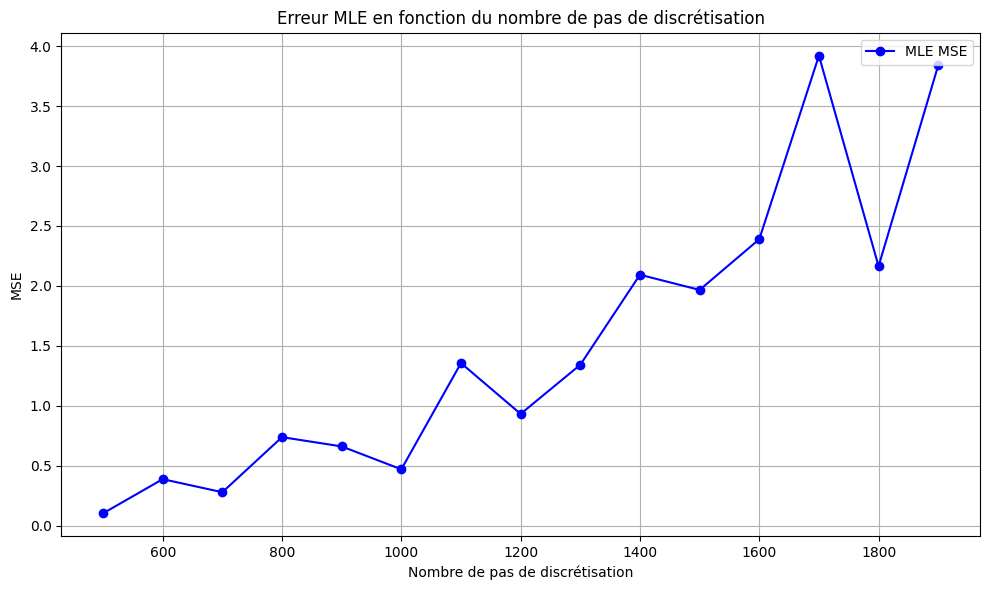

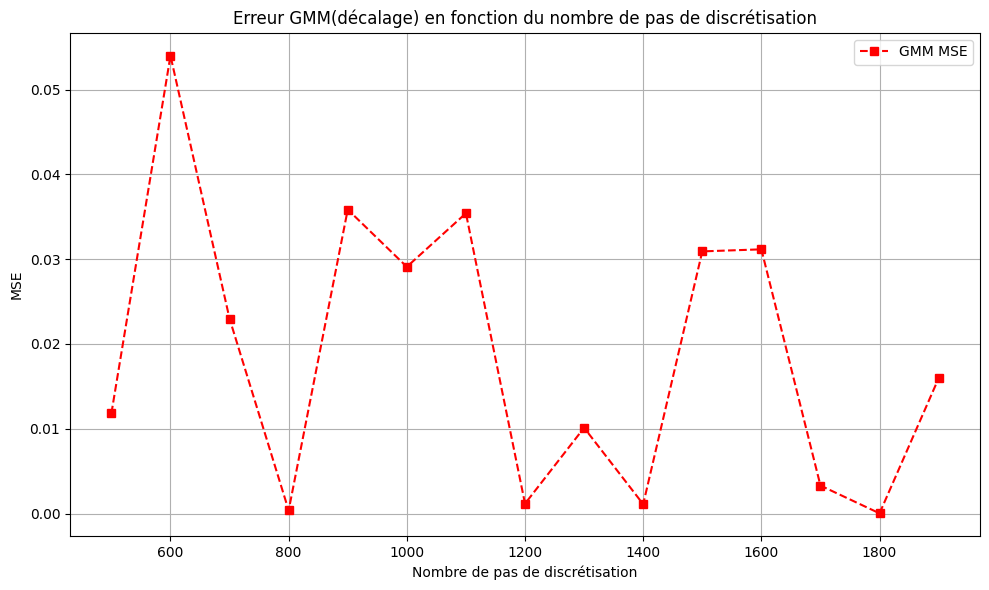

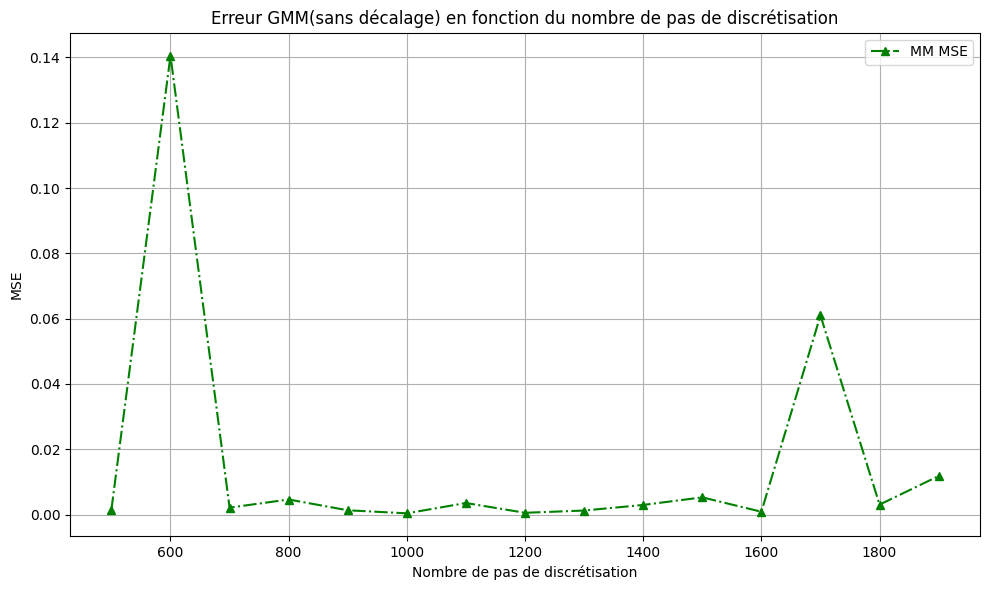

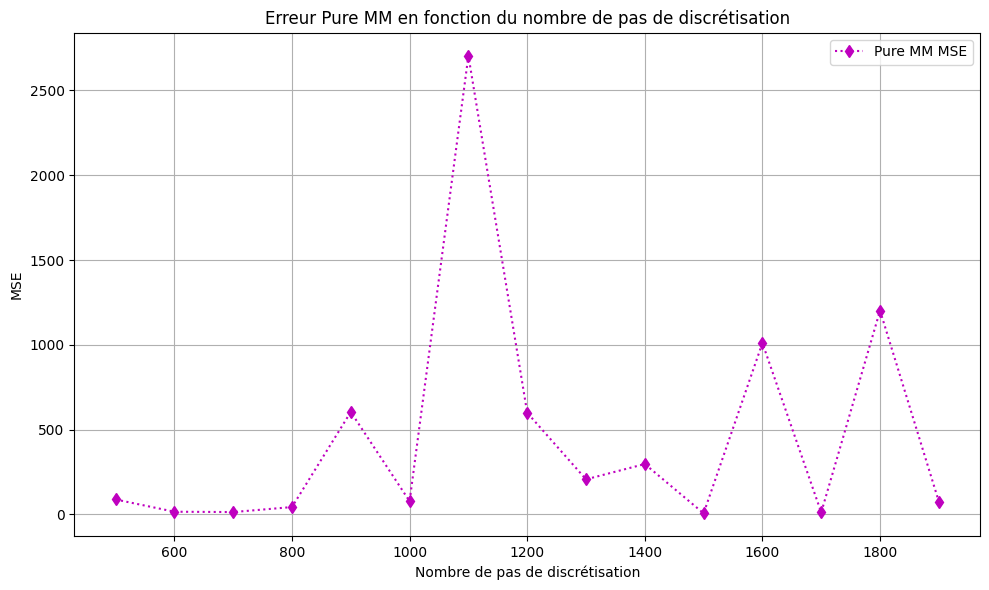

In [ ]:
# Paramètres du processus
n_range = range(500, 2000, 100)

N = 1
X0 = 0.05  # Valeur initiale du processus
kappa_true = 0.9289  # Vitesse de retour à la moyenne
theta_true = 0.09587  # Moyenne long-terme
sigma_true = 0.03389  # Volatilité

MLE_error = []
num_lags = 10
max_order = 6
GMM_error = []
MM_error = []
pure_MM_error = []
for n in n_range:
    T = 100
    vasicek_process = Vasicek(kappa_true, theta_true, sigma_true)
    trajectory = vasicek_process.generate(X0, T, N, n)[0]  # Générer une trajectoire
    trajectory += np.random.normal(0,0.01,n)
    kappa_MLE, theta_MLE, sigma_MLE = estimate_parameters(trajectory, T)

    # Calcul de l'erreur pour le MLE
    MLE_error.append(MSE(
        np.array([kappa_MLE, theta_MLE, sigma_MLE]),
        np.array([kappa_true, theta_true, sigma_true])
    ))

    # Estimation par la méthode des moments (GMM)
    theta_emp = np.mean(trajectory)
    lags = np.array([i * T / n for i in range(num_lags)])  # Éviter trop de lags
    kappa_est, sigma_est = estimate_kappa_sigma(trajectory, n, T, theta_emp, lags)
    GMM_error.append(MSE(
        np.array([kappa_est, theta_emp, sigma_est]),
        np.array([kappa_true, theta_true, sigma_true])
    ))

    theta_hat, sigma2_hat, kappa_hat = moment_estimators(trajectory, T)  # Fix the arguments here
    MM_error.append(MSE(
        np.array([kappa_hat, theta_hat, sigma2_hat]),
        np.array([kappa_true, theta_true, sigma_true])
    ))
    theta_hat,sigma2_hat, kappa_hat,res = pure_moments_calibration(trajectory,max_order)
    pure_MM_error.append([
    np.array([kappa_hat, theta_hat, sigma2_hat]),
    np.array([kappa_true, theta_true, sigma_true])
    ])
# Création des sous-figures pour MLE
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(n_range, MLE_error, label='MLE MSE', marker='o', color='b')
ax.set_xlabel('Nombre de pas de discrétisation')
ax.set_ylabel('MSE')
ax.set_title('Erreur MLE en fonction du nombre de pas de discrétisation')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

# Création des sous-figures pour GMM
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(n_range, GMM_error, label='GMM MSE', marker='s', linestyle='dashed', color='r')
ax.set_xlabel('Nombre de pas de discrétisation')
ax.set_ylabel('MSE')
ax.set_title('Erreur GMM(décalage) en fonction du nombre de pas de discrétisation')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

# Création des sous-figures pour MM
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(n_range, MM_error, label='MM MSE', marker='^', linestyle='-.', color='g')
ax.set_xlabel('Nombre de pas de discrétisation')
ax.set_ylabel('MSE')
ax.set_title('Erreur GMM(sans décalage) en fonction du nombre de pas de discrétisation')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()
# Création des sous-figures pour Pure MM
fig, ax = plt.subplots(figsize=(10, 6))
pure_MM_mse = [MSE(pure_MM_error[i][0], pure_MM_error[i][1]) for i in range(len(pure_MM_error))]
ax.plot(n_range, pure_MM_mse, label='Pure MM MSE', marker='d', linestyle=':', color='m')
ax.set_xlabel('Nombre de pas de discrétisation')
ax.set_ylabel('MSE')
ax.set_title('Erreur Pure MM en fonction du nombre de pas de discrétisation')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

